In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid, solve_ivp

<p align="center">
  <img src="https://github.com/marcus-valmeida/Projeto-conversao/blob/medupl/circuito_exercicio2.png?raw=true" alt="Circuito Exercício 1" width="500"/>
</p>

In [17]:
#Dados da questão
R = 4*1e-2
D = 15*1e-2
N1  = 90
lc = 25*1e-2
U0  = 4*np.pi*1e-7
alpha  = np.pi / 3
g = 2*1e-3
num_pontos = 200

#caso real
CampoMagnetico = np.array([0, 68, 135, 203, 271, 338, 406, 474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000])
DensidadeCampo = np.array([0, 0.733, 1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703,1.724, 1.731, 1.738, 1.761, 1.770, 1.800, 1.816])

#caso linear
CampoMagnetico_linear = np.array([0, 68])
DensidadeCampo_linear = np.array([0, 0.733])

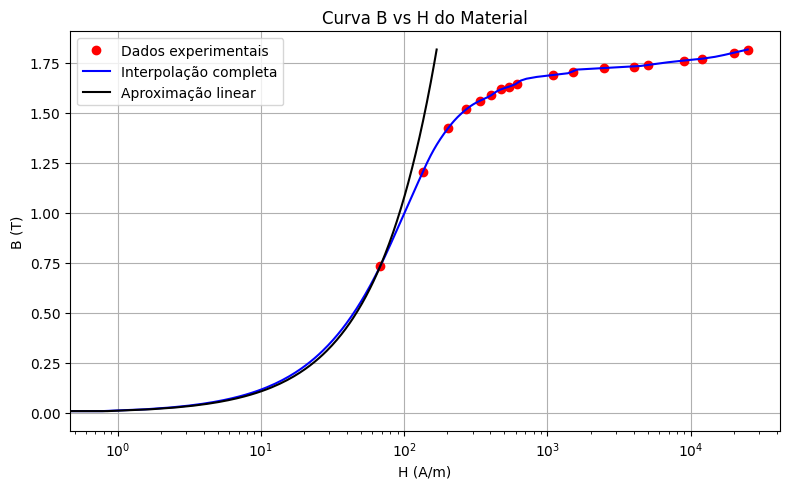

In [18]:
# Interpolação cúbica (ordem crescente de B)
f_real = CubicSpline(DensidadeCampo, CampoMagnetico, bc_type='natural')
f_linear = CubicSpline(DensidadeCampo_linear, CampoMagnetico_linear, bc_type='natural')

# Geração de pontos para interpolação
B_a = np.linspace(min(DensidadeCampo), max(DensidadeCampo), num_pontos)
H_a = f_real(B_a)
H_linear_a = f_linear(B_a)

# Plotagem
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(CampoMagnetico, DensidadeCampo, 'ro', label='Dados experimentais')
ax.plot(H_a, B_a, 'b-', label='Interpolação completa')
ax.plot(H_linear_a, B_a, 'k-', label='Aproximação linear')

ax.set_title('Curva B vs H do Material')
ax.set_xlabel('H (A/m)')
ax.set_ylabel('B (T)')
ax.set_xscale('log')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

#### Considere que o controlador do sistema aplica corrente em apenas uma bobina de cada vez.

- Apresente um gráfico do fluxo concatenado na bobina 1 em função da corrente aplicada nessa bobina considerando a posição do rotor variando da posição 0° até 60°.
    - Observação: seu gráfico terá uma curva de fluxo em função da corrente para cada posição. Se
você fizer o plot para todas as posições que calcular, a figura fica sobre carregada. Sugiro
fazer o plot com cerca de 10 posições diferentes ( ou seja, 0, 6, 12... 60°).

In [39]:
def area_eficaz(theta):

    #limitando de 0 a 360 graus
    theta = np.mod(theta, 2*np.pi)

    #0 até 30 graus
    if (0 <= theta <= np.pi/6):
        return R * D * (np.pi/3 - theta)
    
    #30 até 60 graus ou 120 até 150 graus
    elif (np.pi/6 < theta <= np.pi/3) or (2*np.pi/3 < theta <= 5*np.pi/6):
        return R * D * (np.pi/6)
    
    #150 até 180 graus
    elif (5*np.pi/6 < theta <= np.pi):
        return R * D * (theta - 2*np.pi/3)
    
    else :
        return 0

def fluxo_concatenado(area, corrente, B, operacao, Interpolacao_H_B):

    # Inicialmente iremos calcular a relutância do circuito magnético
    relutancia = np.inf if area == 0 else (2*g)/(U0 * area)

    # Agora podemos calcular o fluxo magnético
    if operacao == "real":

        if area == 0:
            fluxo = 0
            corrente = 0

        else:
            # Como o fluxo no núcleo é o mesmo, e a área dos polos são iguais temos que B0 = B
            B0 = B
            
            # Calcula a intensidade de campo magnético (H) no entreferro (H = B / μ0)
            H0 = B0 / U0

            # Aplica a Lei de Hopkinson para encontrar a corrente necessária
            # Soma (MMF do núcleo + MMF do entreferro) e divide pelo número de espiras
            corrente = (Interpolacao_H_B(B) * lc + 2 * H0 * g) / N1
            
            # Calcula o fluxo concatenado (λ = N * B * A)
            fluxo = B * area * N1 
    
    elif operacao == "linear":
        ## Modelo linear: a relutância é constante, e o fluxo é diretamente proporcional à corrente.
        fluxo = 0 if relutancia == np.inf else ((N1**2) * corrente) / relutancia

    return fluxo, corrente





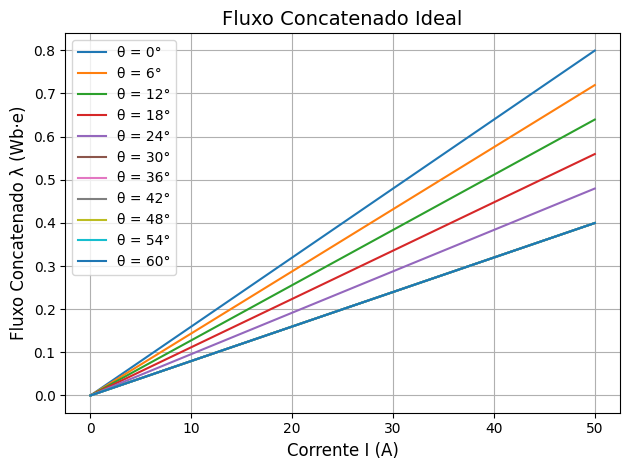

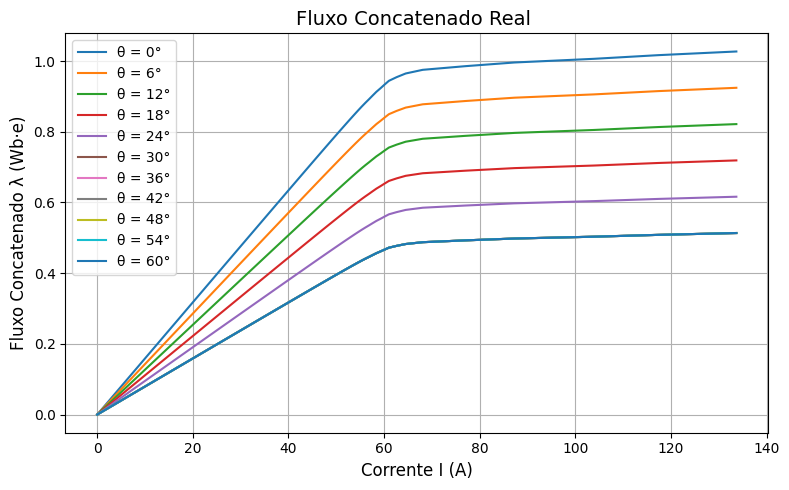

In [ ]:
# Dados para o Fluxo Concatenado Ideal
correntes_linear = np.linspace(0, 50, 300)
angulos_deg = np.linspace(0, 60, 11)
angulos_rad = np.radians(angulos_deg)

plt.figure()
for theta in angulos_rad:
    area = area_eficaz(theta)
    
    # Gera a lista de fluxos ideal para o ângulo atual
    fluxos_ideal = [fluxo_concatenado(area, i, 0.733, "linear", f_linear)[0] for i in correntes_linear]

    plt.plot(correntes_linear, fluxos_ideal, label=f'θ = {np.degrees(theta):.0f}°')

plt.title('Fluxo Concatenado Ideal', fontsize=14)
plt.xlabel('Corrente I (A)', fontsize=12)
plt.ylabel('Fluxo Concatenado λ (Wb·e)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# Dados para o Fluxo Concatenado Real
densidade_campo_real = np.linspace(min(DensidadeCampo), max(DensidadeCampo), 100)

plt.figure(figsize=(8,5))
for theta in angulos_rad:
    area = area_eficaz(theta)
    if area == 0:
        continue
    
    # Gera as listas de fluxos e correntes para o ângulo atual
    fluxo_corrente_real = [fluxo_concatenado(area, None, B, "real", f_real) for B in densidade_campo_real]
    
    fluxos_reais = [item[0] for item in fluxo_corrente_real]
    correntes_reais = [item[1] for item in fluxo_corrente_real]

    plt.plot(correntes_reais, fluxos_reais, label=f'θ = {np.degrees(theta):.0f}°')

plt.title('Fluxo Concatenado Real ', fontsize=14)
plt.xlabel('Corrente I (A)', fontsize=12)
plt.ylabel('Fluxo Concatenado λ (Wb·e)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()